In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython import display

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.reset_default_graph()

In [4]:
BATCH_SIZE = 64
INPUT_SIZE_1D = 784
INPUT_SHAPE = (28,28,1)

def build_inputs():
    input_shape = [BATCH_SIZE] + list(INPUT_SHAPE)
    input_x = tf.placeholder(tf.float32, input_shape)
    input_c1 = tf.placeholder(tf.float32, [BATCH_SIZE, 10]) # one-hot encoded categorical
    input_z = tf.placeholder(tf.float32, [BATCH_SIZE, 64])  # from unif -1, 1
    
    is_train = tf.placeholder(tf.bool)  # needed for batch norm
    
    return input_x, input_c1, input_z, is_train

In [5]:
alpha = 0.10

In [6]:
D_CONV_LAYER1_FILTERS = 64
D_CONV_LAYER1_KERNEL_SIZE = 4
D_CONV_LAYER1_STRIDE = 2

D_CONV_LAYER2_FILTERS = 128
D_CONV_LAYER2_KERNEL_SIZE = 4
D_CONV_LAYER2_STRIDE = 2

D_FC_LAYER3_UNITS = 1024

Q_FC_LAYER4_UNITS = 128
Q_FC_LAYER5_UNITS = 74

# x = image, y = real or fake
#
def build_D_and_Q(x):
    conv1 = tf.layers.conv2d(x, 
                             filters=D_CONV_LAYER1_FILTERS, 
                             kernel_size=D_CONV_LAYER1_KERNEL_SIZE,
                             strides=D_CONV_LAYER1_STRIDE,
                             padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=None)
    # note: no batch norm on first layer, per 1606.03657 appendix C.1
    lrelu1 = tf.maximum(conv1, alpha * conv1)
    
    conv2 = tf.layers.conv2d(lrelu1, 
                             filters=D_CONV_LAYER2_FILTERS,
                             kernel_size=D_CONV_LAYER2_KERNEL_SIZE,
                             strides=D_CONV_LAYER2_STRIDE,
                             padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=None)
    bn2 = tf.layers.batch_normalization(conv2, training=is_train)
    lrelu2 = tf.maximum(bn2, alpha * bn2)
    
    lrelu2_flat = tf.reshape(lrelu2, [BATCH_SIZE, -1])
    
    fc1 = tf.layers.dense(lrelu2_flat, 
                          units=D_FC_LAYER3_UNITS, 
                          activation=None)
    bn3 = tf.layers.batch_normalization(fc1, training=is_train)
    lrelu3 = tf.maximum(bn3, alpha * bn3)
    
    d_logits = tf.layers.dense(lrelu3, units=1, activation=None)
    
    q_features_fc2 = tf.layers.dense(lrelu3, 
                                     units=Q_FC_LAYER4_UNITS, 
                                     activation=None)
    bn4 = tf.layers.batch_normalization(q_features_fc2, training=is_train)
    q_features_lrelu4 = tf.maximum(bn4, alpha * bn4)
    
    q_latents_raw = tf.layers.dense(q_features_lrelu4, 
                                    units=Q_FC_LAYER5_UNITS, 
                                    activation=None)
    
    # For MNIST experiments, the authors use 1 10-dimensional categorical latent var.
    #
    # - The prior distribution is sampled from, and the sample is provided to the generator G.
    #   The prior distribution is a 10-class multinomial distribution 
    #     with p_i=0.10 for all i
    #
    # - The posterior is computed from a given image x, using the recognition network Q.
    #   The posterior is a 10-class multinomial distribution 
    #       with p_i computed via a softmax on 10 outputs from Q with linear activations
    q_latents_categoricals_raw = q_latents_raw[:,0:10]
    q_latents_categoricals_posterior_probs = tf.nn.softmax(q_latents_categoricals_raw, dim=1)
    
    # for MNIST, the authors use 2 continuous random variables 
    #
    # - The prior distribution is sampled from, and the sample is provided to the generator G.
    #   The prior distribution is a uniform distribution over (-1, 1).
    #
    # - The posterior is computed from a given image x, using the recognition network Q.
    #   The posterior is a gaussian distribution 
    #       with mu computed directly by an output from Q with a linear activation
    #       and sigma fixed at 1.0.
    #
    q_latents_continuous_raw = q_latents_raw[:,10:12]
    q_latents_continuous_posterior_mean = q_latents_continuous_raw
    
    q_latents_noise_raw = q_latents_raw[:,12:]
    
    return d_logits, q_latents_categoricals_posterior_probs, q_latents_continuous_posterior_mean, q_latents_noise_raw

In [7]:
x, c1, z, is_train = build_inputs()

In [8]:
c2 = z[:, 0]
c3 = z[:, 1]
z_noise = z[:, 2:]

In [9]:
with tf.variable_scope("discriminator"):
    d_logits_real, c1_posterior_real, c2c3_posterior_mu_real, z_noise_posterior_mu_real = build_D_and_Q(x)

In [10]:
G_FC_LAYER1_UNITS = 1024
G_FC_LAYER2_UNITS = 7 * 7 * 128

G_TRANSPOSECONV_LAYER3_FILTERS = 64
G_TRANSPOSECONV_LAYER3_KERNEL_SIZE = 4
G_TRANSPOSECONV_LAYER3_STRIDE = 2

G_TRANSPOSECONV_LAYER4_FILTERS = 1
G_TRANSPOSECONV_LAYER4_KERNEL_SIZE = 4
G_TRANSPOSECONV_LAYER4_STRIDE = 2

# x = image, y = real or fake
#
def build_G(c1, z):
    input_combined = tf.concat([c1, z], axis=1)
    
    g_fc1 = tf.layers.dense(input_combined, G_FC_LAYER1_UNITS)
    g_bn1 = tf.layers.batch_normalization(g_fc1, training=is_train)
    g_relu1 = tf.nn.relu(g_bn1)
    
    g_fc2 = tf.layers.dense(g_relu1, G_FC_LAYER2_UNITS)
    g_bn2 = tf.layers.batch_normalization(g_fc2, training=is_train)
    g_relu2 = tf.nn.relu(g_bn2)
    g_relu2_reshaped = tf.reshape(g_relu2, [BATCH_SIZE, 7, 7, 128])
    
    g_tconv1 = tf.layers.conv2d_transpose(g_relu2_reshaped, 
                                          filters=G_TRANSPOSECONV_LAYER3_FILTERS,
                                          kernel_size=G_TRANSPOSECONV_LAYER3_KERNEL_SIZE,
                                          strides=G_TRANSPOSECONV_LAYER3_STRIDE,
                                          padding='same',
                                          activation=None)
    g_bn3 = tf.layers.batch_normalization(g_tconv1, training=is_train)
    g_relu3 = tf.nn.relu(g_bn3)
    
    g_tconv2 = tf.layers.conv2d_transpose(g_relu3, 
                                          filters=G_TRANSPOSECONV_LAYER4_FILTERS,
                                          kernel_size=G_TRANSPOSECONV_LAYER4_KERNEL_SIZE,
                                          strides=G_TRANSPOSECONV_LAYER4_STRIDE,
                                          padding='same',
                                          activation=None)
    pixels = tf.nn.sigmoid(g_tconv2)
    return pixels

In [11]:
with tf.variable_scope("generator"):
    fake_x = build_G(c1, z)

In [12]:
with tf.variable_scope("discriminator", reuse=True):
    d_logits_fake, c1_posterior_fake, c2c3_posterior_mu_fake, z_noise_posterior_mu_fake = build_D_and_Q(fake_x)

In [13]:
tf.trainable_variables()

[<tf.Variable 'discriminator/conv2d/kernel:0' shape=(4, 4, 1, 64) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d_1/kernel:0' shape=(4, 4, 64, 128) dtype=float32_ref>,
 <tf.Variable 'discriminator/conv2d_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminator/batch_normalization/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminator/batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense/kernel:0' shape=(6272, 1024) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'discriminator/batch_normalization_1/beta:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'discriminator/batch_normalization_1/gamma:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense_1/kernel:0' shape=(1024, 1) dtype=float32_ref>,
 <tf.Variable 'discriminator/dense_1/bias:0' shape=(1,) d

In [14]:
fake_x.get_shape().as_list()

[64, 28, 28, 1]

In [15]:
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones(dtype=tf.float32, shape=[BATCH_SIZE, 1])
    )
)

d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros(dtype=tf.float32, shape=[BATCH_SIZE, 1])
    )
)

In [16]:
g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones(dtype=tf.float32, shape=[BATCH_SIZE, 1])
    )
)

In [17]:
d_loss = d_loss_real + d_loss_fake

In [18]:
c1_prior = 0.10 * tf.ones(dtype=tf.float32, shape=[BATCH_SIZE, 10])

c2_prior_mu = tf.zeros(dtype=tf.float32, shape=[BATCH_SIZE])
c2_prior_sigma = tf.ones(dtype=tf.float32, shape=[BATCH_SIZE])

c3_prior_mu = tf.zeros(dtype=tf.float32, shape=[BATCH_SIZE])
c3_prior_sigma = tf.ones(dtype=tf.float32, shape=[BATCH_SIZE])

In [19]:
log_q_c1_given_x = tf.reduce_sum(
    c1 * tf.log(tf.clip_by_value(c1_posterior_fake, 1e-12, 1.0)),
    axis=-1
)
log_q_c1 = tf.reduce_sum(
    c1 * tf.log(tf.clip_by_value(c1_prior, 1e-12, 1.0)),
    axis=-1
)

In [20]:
c2_posterior_mu_fake = c2c3_posterior_mu_fake[:,0]
c2_posterior_sigma_fake = tf.ones(dtype=tf.float32, shape=[BATCH_SIZE])

c2_standardized_against_gaussian_prior = (c2 - c2_prior_mu) / c2_prior_sigma
c2_standardized_against_posterior = (c2 - c2_posterior_mu_fake) / c2_posterior_sigma_fake

log_q_c2_given_x = - 0.5 * np.log(2 * np.pi) - tf.log(c2_posterior_sigma_fake + 1e-12) - 0.5 * tf.square(c2_standardized_against_posterior)
log_q_c2 = - 0.5 * np.log(2 * np.pi) - tf.log(c2_prior_sigma + 1e-12) - 0.5 * tf.square(c2_standardized_against_gaussian_prior)

In [21]:
c3_posterior_mu_fake = c2c3_posterior_mu_fake[:,1]
c3_posterior_sigma_fake = tf.ones(dtype=tf.float32, shape=[BATCH_SIZE])

c3_standardized_against_gaussian_prior = (c3 - c3_prior_mu) / c3_prior_sigma
c3_standardized_against_posterior = (c3 - c3_posterior_mu_fake) / c3_posterior_sigma_fake

log_q_c3_given_x = - 0.5 * np.log(2 * np.pi) - tf.log(c3_posterior_sigma_fake + 1e-12) - 0.5 * tf.square(c3_standardized_against_posterior)
log_q_c3 = - 0.5 * np.log(2 * np.pi) - tf.log(c3_prior_sigma + 1e-12) - 0.5 * tf.square(c3_standardized_against_gaussian_prior)

In [22]:
log_q_c_given_x = log_q_c1_given_x + log_q_c2_given_x + log_q_c3_given_x
log_q_c = log_q_c1 + log_q_c2 + log_q_c3

In [23]:
lowerbound_for_neg_conditional_entropy_of_c_given_x = tf.reduce_mean(log_q_c_given_x)
entropy_of_c = -tf.reduce_mean(log_q_c)

# mutual_information_between_c_and_x = entropy_of_c - conditional_entropy_of_c_given_x 
lowerbound_for_mutual_information_between_c_and_x = entropy_of_c + lowerbound_for_neg_conditional_entropy_of_c_given_x 

In [24]:
d_loss -= lowerbound_for_mutual_information_between_c_and_x
g_loss -= lowerbound_for_mutual_information_between_c_and_x

In [25]:
def model_opt(d_loss, g_loss, d_lr, g_lr):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(d_lr).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(g_lr).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [26]:
d_opt, g_opt = model_opt(d_loss, g_loss, 2e-4, 2e-4)

In [27]:
session = tf.InteractiveSession()

In [28]:
session.run(tf.global_variables_initializer())

In [29]:
ident = np.eye(10)

In [30]:
ident[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [31]:
def visualize_training(c_variable, fake_xs, nr_rows=4, one_hot=True):
    
    if one_hot:
        # recovers int from one-hot class
        c1_scalar_input = np.argmax(c_variable, 1)
    else:
        c1_scalar_input = c_variable
    
    # then obtain idxs for sorting batch of fake samples by specified c1 class
    sort_idxs = np.argsort(c1_scalar_input, 0)
    
    fake_xs_2d = np.reshape(fake_xs[sort_idxs], [BATCH_SIZE, 28, 28])
    
    zpt = fake_xs_2d
    zpt_reshaped = np.reshape(
        np.expand_dims(zpt, axis=0), 
        [nr_rows, (BATCH_SIZE // nr_rows), 28, 28]
    )
    row_results = []
    for i in range(0,nr_rows):
        row = np.concatenate(
            [zpt_reshaped[i,j,:,:] for j in range(0,(BATCH_SIZE // nr_rows))], 
            axis=1
        )
        row_results.append(row)
    return np.concatenate(row_results, axis=0)

In [32]:
show_every = 100
print_every = 5
total_epochs = 100

losses = []

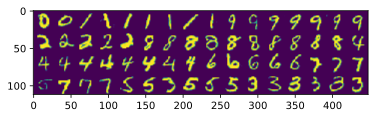

Epoch 49/100... Discriminator Loss: -2.185684... Generator Loss: 0.620749


KeyboardInterrupt: 

In [33]:

for epoch in range(total_epochs):
    for steps in range(0, mnist.train.num_examples // BATCH_SIZE):
        x_batch, _ = mnist.train.next_batch(BATCH_SIZE)
        x_batch = np.reshape(x_batch, (BATCH_SIZE, 28, 28, 1))
        c1_ints_batch = np.random.randint(low=0, high=10, size=(BATCH_SIZE,))
        c1_onehot_batch = ident[c1_ints_batch]
        z_batch = np.random.uniform(low=-1.0, high=1.0, size=(BATCH_SIZE,64))
        feed_dict={x: x_batch, c1: c1_onehot_batch, z: z_batch, is_train: True}
        _ = session.run(d_opt, feed_dict=feed_dict)
        _ = session.run(g_opt, feed_dict=feed_dict)
        if steps % print_every == 0:
            # At the end of each epoch, get the losses and print them out
            display.clear_output(wait=True)
            
            train_loss_d = d_loss.eval(feed_dict)
            train_loss_g = g_loss.eval(feed_dict)
            
            _fake_x = fake_x.eval(feed_dict)
            plt.imshow(visualize_training(c1_onehot_batch, _fake_x))
            plt.show()

            print("Epoch {}/{}...".format(epoch+1, total_epochs),
                  "Discriminator Loss: {:.6f}...".format(train_loss_d),
                  "Generator Loss: {:.6f}".format(train_loss_g))
                    
            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))

In [154]:
x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
x_batch = np.reshape(x_batch, (BATCH_SIZE, 28, 28, 1))
c1_ints_batch = np.array([(i // 10) for i in range(0,64)])
c1_onehot_batch = ident[c1_ints_batch]
z_batch = np.random.uniform(low=-1.0, high=1.0, size=(BATCH_SIZE,64))
feed_dict={x: x_batch, c1: c1_onehot_batch, z: z_batch, is_train: True}

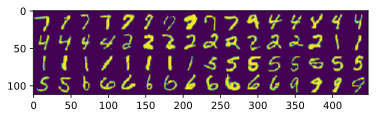

In [155]:
display.clear_output(wait=True)

_fake_x = fake_x.eval(feed_dict)
plt.imshow(visualize_training(c1_onehot_batch, _fake_x))
plt.show()

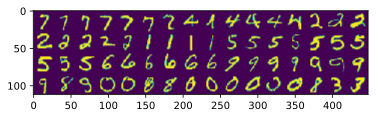

In [156]:
display.clear_output(wait=True)

_c1_posterior_real = c1_posterior_real.eval(feed_dict)

plt.imshow(visualize_training(_c1_posterior_real, x_batch))
plt.show()

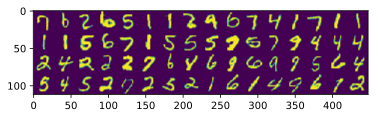

In [157]:
display.clear_output(wait=True)

_fake_x = fake_x.eval(feed_dict)
plt.imshow(visualize_training(np.expand_dims(z_batch[:,0], 1), _fake_x, one_hot=False))
plt.show()

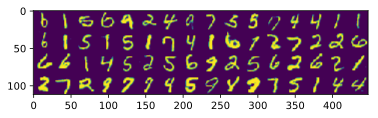

In [158]:
display.clear_output(wait=True)

_fake_x = fake_x.eval(feed_dict)
plt.imshow(visualize_training(np.expand_dims(z_batch[:,1], 1), _fake_x, one_hot=False))
plt.show()